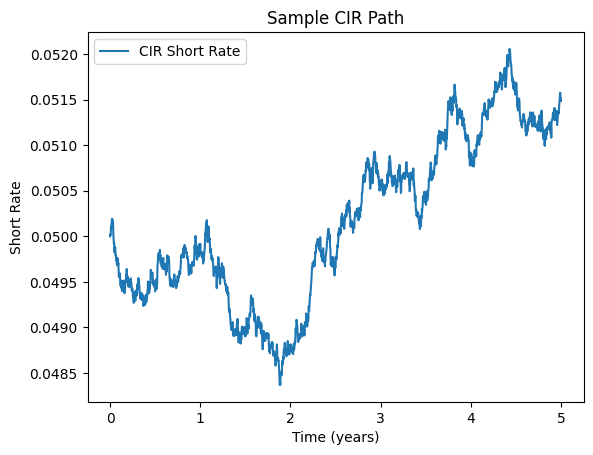

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_CIR(a, b, sigma, r0, T=5.0, N=2000, seed=42):
    np.random.seed(seed)
    dt = T / N
    times = np.linspace(0, T, N+1)
    r = np.zeros(N+1)
    r[0] = r0

    for i in range(1, N+1):
        epsilon = np.random.normal(0, np.sqrt(dt))
        # Floor the previous rate at zero to avoid negative sqrt
        r_prev = max(r[i-1], 0.0)
        r[i] = (r[i-1]
                + a * (b - r[i-1]) * dt
                + sigma * np.sqrt(r_prev) * epsilon*np.sqrt(dt))

    return times, r


a_ex = 0.05
b_ex = 0.04
sigma_ex = 0.08
r0_ex = 0.05

times_ex, r_ex = simulate_CIR(a_ex, b_ex, sigma_ex, r0_ex)

plt.plot(times_ex, r_ex, label="CIR Short Rate")
plt.title("Sample CIR Path")
plt.xlabel("Time (years)")
plt.ylabel("Short Rate")
plt.legend()

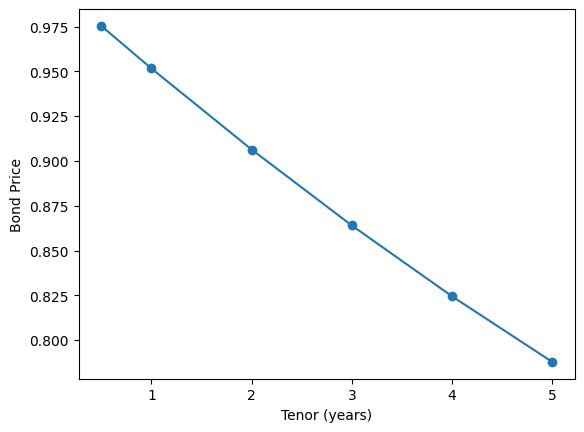

In [13]:
def simulate_CIR_paths_vectorized(a, b, sigma, r0, T=5.0, N=2000, M=10000, seed=42):
    np.random.seed(seed)
    dt = T / N
    times = np.linspace(0, T, N+1)
    r_paths = np.zeros((M, N+1))
    r_paths[:, 0] = r0
    epsilons = np.random.normal(0.0, 1.0, (M, N))
    for i in range(1, N+1):
        r_prev = np.maximum(r_paths[:, i-1], 0.0)
        r_paths[:, i] = (
            r_paths[:, i-1]
            + a * (b - r_paths[:, i-1]) * dt
            + sigma * np.sqrt(r_prev) * epsilons[:, i-1] * np.sqrt(dt)
        )
    return times, r_paths

def compute_discount_factors(r_paths, dt):
    return np.cumsum(r_paths[:, :-1], axis=1) * dt

def zero_coupon_bond_price_from_partial_sums(partial_sums, idx):
    integrals = partial_sums[:, idx]
    return np.mean(np.exp(-integrals))

def zero_coupon_bond_price_for_tenors(r_paths, times, tenors):
    dt = times[1] - times[0]
    partial_sums = compute_discount_factors(r_paths, dt)
    prices = []
    for tnr in tenors:
        idx = np.searchsorted(times, tnr)
        if idx >= partial_sums.shape[1]:
            idx = partial_sums.shape[1] - 1
        prices.append(zero_coupon_bond_price_from_partial_sums(partial_sums, idx))
    return prices

if __name__ == "__main__":
    a, b, sigma, r0 = 0.05, 0.04, 0.08, 0.05
    T, N, M = 5.0, 2000, 10000
    times, r_paths = simulate_CIR_paths_vectorized(a, b, sigma, r0, T, N, M)
    tenors = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
    prices = zero_coupon_bond_price_for_tenors(r_paths, times, tenors)
    plt.plot(tenors, prices, marker='o')
    plt.xlabel("Tenor (years)")
    plt.ylabel("Bond Price")

感觉后面麻烦的就是这个最小化。估计要费时间，我这做的不太对

fix_mask：用布尔值列表 [a_fix, b_fix, sigma_fix] 指示哪些参数暂时“冻结”。
calibration_error：根据 fix_mask，只从 params 里拿对应的可调参数，其他用默认或上一步结果。
run_calibration_step：封装了单步优化逻辑，方便分阶段调用。
多阶段示例：
Stage 1：只优化
(
𝑏
,
𝜎
)
(b,σ)，a 固定。
Stage 2：把 Stage 1 的结果当作固定值，只优化 a。
Stage 3：用 Stage 2 得到的
(
𝑎
,
𝑏
,
𝜎
)
(a,b,σ) 作为起点，一次性优化全部。
最终：用校准好的参数模拟更多路径并画图，与市场数据进行对比。

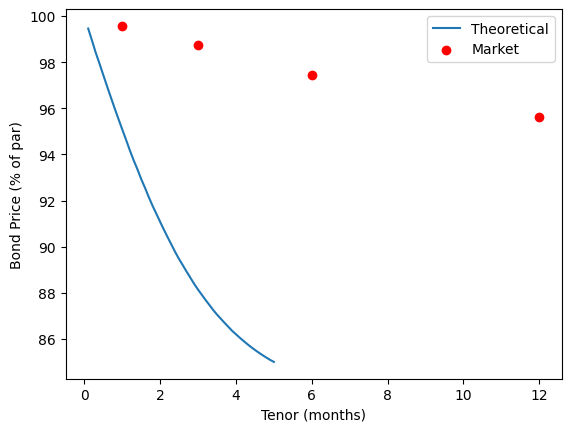

In [18]:
from scipy.optimize import minimize

def calibration_error(params, market_tenors, market_prices, r0, T=5.0, N=2000, M=5000, seed=123, fix_mask=None):
    full_params = np.array([0.2, 0.04, 0.12])
    if fix_mask is None:
        fix_mask = [False, False, False]
    idx_to_use = 0
    for i in range(3):
        if not fix_mask[i]:
            full_params[i] = params[idx_to_use]
            idx_to_use += 1
    a, b, sigma = full_params
    times, r_paths = simulate_CIR_paths_vectorized(a, b, sigma, r0, T, N, M, seed)
    dt = times[1] - times[0]
    partial_sums = np.cumsum(r_paths[:, :-1], axis=1) * dt
    err = 0.0
    for tnr, mkt in zip(market_tenors, market_prices):
        idx = np.searchsorted(times, tnr)
        if idx >= partial_sums.shape[1]:
            idx = partial_sums.shape[1] - 1
        p_sim = np.mean(np.exp(-partial_sums[:, idx])) * 100
        err += (p_sim - mkt) ** 2
    return err

def run_calibration_step(fix_mask, init_guess, market_tenors, market_prices, r0_market):
    bounds_full = [(0.0001,2.0), (0.0,0.2), (0.0001,0.5)]
    reduced_bounds = [bounds_full[i] for i in range(3) if not fix_mask[i]]
    res = minimize(
        calibration_error,
        init_guess,
        args=(market_tenors, market_prices, r0_market, 5.0, 2000, 5000, 123, fix_mask),
        bounds=reduced_bounds,
        method='L-BFGS-B'
    )
    full_params = np.array([0.2, 0.04, 0.12])
    idx_to_use = 0
    for i in range(3):
        if not fix_mask[i]:
            full_params[i] = res.x[idx_to_use]
            idx_to_use += 1
    return full_params, res.fun

if __name__ == "__main__":
    market_tenors = np.array([1/12, 3/12, 6/12, 1.0])
    market_prices = np.array([99.57, 98.73, 97.45, 95.62])
    r0_market = 0.052
    fix_mask_1 = [True, False, False]
    init_guess_1 = [0.04, 0.12]
    params_stage1, err1 = run_calibration_step(fix_mask_1, init_guess_1, market_tenors, market_prices, r0_market)
    fix_mask_2 = [False, True, True]
    b_s1 = params_stage1[1]
    sigma_s1 = params_stage1[2]
    init_guess_2 = [0.2]
    params_stage2, err2 = run_calibration_step(fix_mask_2, init_guess_2, market_tenors, market_prices, r0_market)
    final_init = [params_stage2[0], b_s1, sigma_s1]
    res_final = minimize(
        calibration_error,
        final_init,
        args=(market_tenors, market_prices, r0_market),
        bounds=[(0.0001,2.0),(0.0,0.2),(0.0001,0.5)],
        method='L-BFGS-B'
    )
    final_params = res_final.x
    a_cal, b_cal, sigma_cal = final_params
    T, N, M = 5.0, 1000, 20000
    times, r_paths = simulate_CIR_paths_vectorized(a_cal, b_cal, sigma_cal, r0_market, T, N, M)
    tenors_plot = np.linspace(0.1, T, 50)
    dt = times[1] - times[0]
    partial_sums = np.cumsum(r_paths[:, :-1], axis=1) * dt
    def bond_price(t):
        idx = np.searchsorted(times, t)
        if idx >= partial_sums.shape[1]:
            idx = partial_sums.shape[1] - 1
        return np.mean(np.exp(-partial_sums[:, idx])) * 100
    prices_theoretical = [bond_price(t) for t in tenors_plot]
    plt.plot(tenors_plot, prices_theoretical, label='Theoretical')
    plt.scatter(market_tenors*12, market_prices, color='red', label='Market')
    plt.xlabel("Tenor (months)")
    plt.ylabel("Bond Price (% of par)")
    plt.legend()
    plt.show()

In [19]:
final_params

array([1.00073569e-04, 2.00000000e-01, 3.96641510e-01])

Theoretical form

In [15]:
def cir_bond_price(a, b, sigma, r0, T):
    gamma = np.sqrt(a*a + 2*sigma*sigma)
    numerator = (a + gamma)*(np.exp(gamma*T) - 1) + 2*gamma
    B = 2*(np.exp(gamma*T) - 1) / numerator
    A = ((2*gamma * np.exp((a+gamma)*T/2)) / numerator) ** (2*a*b/(sigma*sigma))
    return A * np.exp(-B*r0)

def cir_bond_price_error(params, market_tenors, market_prices, r0):
    a, b, sigma = params
    err = 0.0
    for tnr, p_mkt in zip(market_tenors, market_prices):
        p_theo = cir_bond_price(a, b, sigma, r0, tnr)*100
        err += (p_theo - p_mkt)**2
    return err

if __name__ == "__main__":
    market_tenors = np.array([1/12, 3/12, 6/12, 1.0])
    market_prices = np.array([99.57, 98.73, 97.45, 95.62])
    r0_market = 0.052
    init_guess = [0.05, 0.04, 0.08]
    bounds = [(0.0001, 2.0), (0.0, 0.2), (0.0001, 0.5)]
    res = minimize(cir_bond_price_error, init_guess, args=(market_tenors, market_prices, r0_market),
                   bounds=bounds, method='L-BFGS-B')
    print("Calibrated parameters (closed-form):", res.x)

Calibrated parameters (closed-form): [0.29011527 0.00199976 0.14385794]
